In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import KFold

# re is used for cleaning the dataset 

import re
import tensorflow as tf
from tensorflow import keras
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from nltk.corpus import stopwords
from tensorflow.keras.layers import Embedding,Conv1D,LSTM ,Dense, Dropout, MaxPooling1D, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score ,cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [9]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data and basic explanation

In [10]:
df = pd.read_csv('/content/IMDB Dataset.csv')
df['sentiment'] = np.where(df['sentiment'] == 'positive', 1, 0)

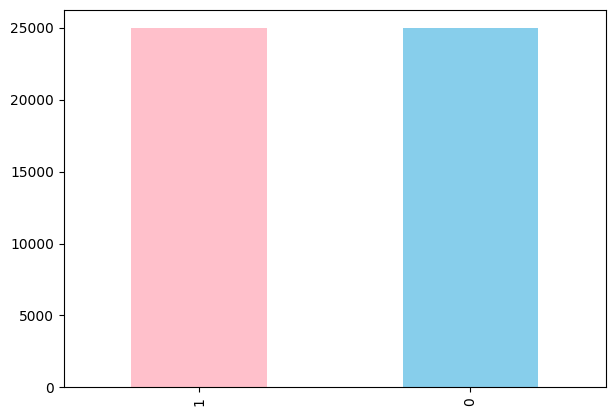

In [11]:
df['sentiment'].value_counts().plot(kind = 'bar', color =[ 'pink', 'skyblue'])

In [12]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [13]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [14]:
df = df.drop_duplicates('review')

In [15]:
# data before cleaning 
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# WordCloud of positive and negative reviews

(-0.5, 799.5, 799.5, -0.5)

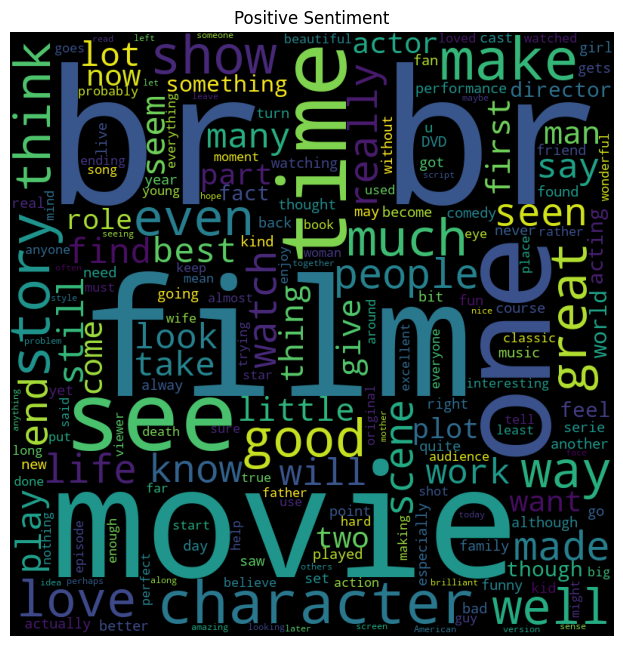

In [16]:
sentences=df['review']
stopwords = set(STOPWORDS) 
pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

(-0.5, 799.5, 799.5, -0.5)

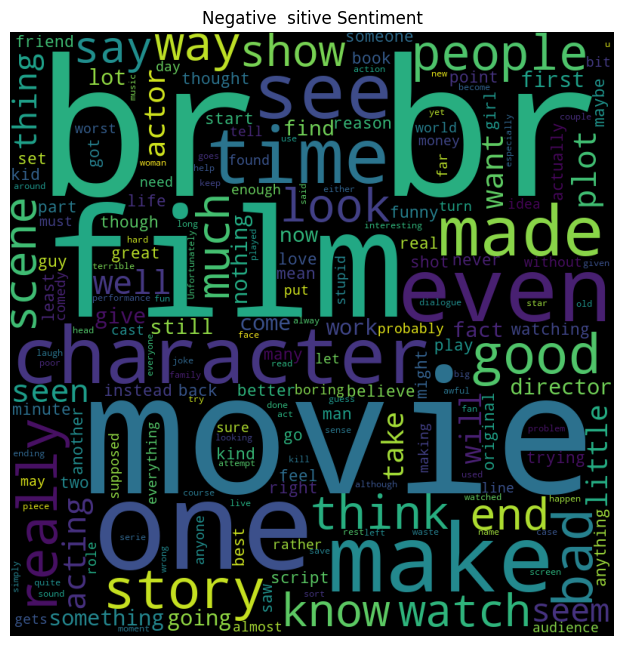

In [17]:
#Negative WordCloud
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud2)
plt.title('Negative  sitive Sentiment')
plt.axis('off')

In [18]:
#cleane method 
#stop_words = set(stopwords.words('english'))

def data_processing(text):
    
    text = re.sub('', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    #filtered_text = [w for w in text.lower() if not w in stop_words]
    #" ".join(filtered_text)
    words = [word.lower() for word in text.split() if word not in stopwords]
    new_text = " ".join(words)
    return new_text
df.review = df['review'].apply(data_processing)

In [19]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data
df.review = df['review'].apply(lambda x: stemming(x))

In [20]:
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,181
1,a wonderful little production br br the filmin...,1,97
2,i thought wonderful way spend time hot summer ...,1,96
3,basically theres family little boy jake thinks...,0,76
4,petter matteis love time money visually stunni...,1,138


In [21]:
#training
X = df['review']
#target
Y = df['sentiment']

In [22]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)
if num_words is None:
    num_words = len(tokenizer.word_index)

In [23]:
# create numeric sequences representation of text
x_tokens = tokenizer.texts_to_sequences(X)

#number of tokens
num_tokens = [len(tokens) for tokens in x_tokens ]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)


In [24]:
#padding 
pad = 'pre'
x_pad = pad_sequences(x_tokens, maxlen=max_tokens, padding=pad, truncating=pad)

# Build Deep Learning Model

## First experiment: DL model GRU

In [25]:
def create_model():
    # create model
    model = Sequential()
    embedding_size = 8
    model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
    
    #model.add(GRU(units=16, return_sequences=True))
    model.add(GRU(units=8, return_sequences=True))
    model.add(GRU(units=4))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [26]:
#define our accuracy metric
metrics = ['accuracy', 'precision', 'recall', 'f1']
estimator = KerasClassifier(build_fn=create_model, epochs=1, batch_size=64,     verbose=0)
result = cross_validate(estimator, x_pad, Y, scoring=metrics, cv=10 , return_train_score=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


1395/1395 [==============================] - 46s 33ms/step


In [27]:
#store average of all 4 metrics of first model in train and test 
train_acc_avg = result['train_accuracy'].mean() 
test_acc_avg = result['test_accuracy'].mean()
train_prec_avg = result['train_precision'].mean()
test_prec_avg= result['test_precision'].mean()
train_recall = result['train_recall'].mean()
test_recall = result['test_recall'].mean()
train_f1 = result['train_f1'].mean()
test_f1 = result['test_f1'].mean()

#srore standard deviation of all 4 metrics of first model in train and test 
train_acc_sd = result['train_accuracy'].std() 
test_acc_sd = result['test_accuracy'].std()
train_prec_sd = result['train_precision'].std()
test_prec_sd= result['test_precision'].std()
train_recall_sd = result['train_recall'].std()
test_recall_sd = result['test_recall'].std()
train_f1_sd = result['train_f1'].std()
test_f1_sd = result['test_f1'].std()

In [28]:
from colorama import Fore
print(Fore.RED + 'Average of 10 fold cross validation of GRU DL model and Standard deviation')
print(Fore.BLACK+"train Accuracy Average: {:.2%} \tStandard deviation: {:.2%}".format(train_acc_avg, train_acc_sd))
print("test Accuracy Average: {:.2%} \tStandard deviation: {:.2%}".format(test_acc_avg, test_acc_sd))
print('----------------------------------------------------------------------------')
print("train Precision Average: {:.2%}\tStandard deviation: {:.2%}".format(train_prec_avg , train_prec_sd))
print("test Precision Average: {:.2%} \tStandard deviation: {:.2%}".format(test_prec_avg , test_prec_sd))
print('----------------------------------------------------------------------------')
print("train Recall: Average: {:.2%} \tStandard deviation: {:.2%}".format(train_recall , train_recall_sd))
print("test Recall: Average: {:.2%} \tStandard deviation: {:.2%}".format(test_recall, test_recall_sd ))
print('----------------------------------------------------------------------------')
print("train F1: Average: {:.2%} \tStandard deviation: {:.2%}".format(train_f1, train_f1_sd ))
print("test F1: Average: {:.2%} \tStandard deviation: {:.2%}".format(test_f1 , test_f1_sd))

Average of 10 fold cross validation of GRU DL model and Standard deviation
train Accuracy Average: 91.52% 	Standard deviation: 0.89%
test Accuracy Average: 87.76% 	Standard deviation: 1.14%
----------------------------------------------------------------------------
train Precision Average: 90.83%	Standard deviation: 1.90%
test Precision Average: 87.09% 	Standard deviation: 2.51%
----------------------------------------------------------------------------
train Recall: Average: 92.51% 	Standard deviation: 1.45%
test Recall: Average: 88.86% 	Standard deviation: 1.98%
----------------------------------------------------------------------------
train F1: Average: 91.64% 	Standard deviation: 0.80%
test F1: Average: 87.92% 	Standard deviation: 1.11%


# First Improvement of DL model: using Long Short Term Memory (LSTM)

In [29]:
def create2_model():
    # create model
    model = Sequential()
    embedding_size = 32
    model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
    
    model.add(LSTM(100))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [30]:
#define our accuracy metric
metrics = ['accuracy', 'precision', 'recall', 'f1']
estimator = KerasClassifier(build_fn=create2_model, epochs=1, batch_size=64,     verbose=0)
result2 = cross_validate(estimator, x_pad, Y, scoring=metrics, cv=10 , return_train_score=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


1395/1395 [==============================] - 91s 65ms/step


In [31]:
#store average of all 4 metrics of first improvement DL model in train and test 
train2_acc_avg = result2['train_accuracy'].mean() 
test2_acc_avg = result2['test_accuracy'].mean()
train2_prec_avg = result2['train_precision'].mean()
test2_prec_avg= result2['test_precision'].mean()
train2_recall = result2['train_recall'].mean()
test2_recall = result2['test_recall'].mean()
train2_f1 = result2['train_f1'].mean()
test2_f1 = result2['test_f1'].mean()

#srore standard deviation of all 4 metrics of first improvement DL in train and test 
train2_acc_sd = result2['train_accuracy'].std() 
test2_acc_sd = result2['test_accuracy'].std()
train2_prec_sd = result2['train_precision'].std()
test2_prec_sd= result2['test_precision'].std()
train2_recall_sd = result2['train_recall'].std()
test2_recall_sd = result2['test_recall'].std()
train2_f1_sd = result2['train_f1'].std()
test2_f1_sd = result2['test_f1'].std()

In [32]:
from colorama import Fore
print(Fore.RED + 'Average of 10 fold cross validation and Standard deviation of First Improvement of DL model: using (LSTM) ')
print(Fore.BLACK+"train Accuracy Average: {:.2%}\tStandard deviation: {:.2%}".format(train2_acc_avg, train2_acc_sd))
print("test Accuracy Average: {:.2%}\tStandard deviation: {:.2%}".format(test2_acc_avg, test2_acc_sd))
print('----------------------------------------------------------------------------')
print("train Precision Average: {:.2%}\tStandard deviation: {:.2%}".format(train2_prec_avg , train2_prec_sd))
print("test Precision Average: {:.2%}\tStandard deviation: {:.2%}".format(test2_prec_avg , test2_prec_sd))
print('----------------------------------------------------------------------------')
print("train Recall: Average: {:.2%}\tStandard deviation: {:.2%}".format(train2_recall , train2_recall_sd))
print("test Recall: Average: {:.2%} \tStandard deviation: {:.2%}".format(test2_recall, test2_recall_sd ))
print('----------------------------------------------------------------------------')
print("train F1: Average: {:.2%}\tStandard deviation: {:.2%}".format(train2_f1, train2_f1_sd ))
print("test F1: Average: {:.2%}\tStandard deviation: {:.2%}".format(test2_f1 , test2_f1_sd))

Average of 10 fold cross validation and Standard deviation of First Improvement of DL model: using (LSTM) 
train Accuracy Average: 92.51%	Standard deviation: 0.93%
test Accuracy Average: 88.84%	Standard deviation: 1.13%
----------------------------------------------------------------------------
train Precision Average: 92.37%	Standard deviation: 1.37%
test Precision Average: 88.59%	Standard deviation: 1.76%
----------------------------------------------------------------------------
train Recall: Average: 92.77%	Standard deviation: 1.35%
test Recall: Average: 89.29% 	Standard deviation: 1.39%
----------------------------------------------------------------------------
train F1: Average: 92.56%	Standard deviation: 0.91%
test F1: Average: 88.92%	Standard deviation: 1.11%


# Second Improvement of DL ( 3 CNN layers + LSTM)

In [33]:
def create_3model():
    # create model
    model = Sequential()
    embedding_size = 8
    model.add(Embedding(input_dim=num_words,output_dim=embedding_size,input_length=max_tokens,name='layer_embedding'))
    # CNN1
    model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    #CNN2
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    
    #CNN3
    model.add(Conv1D(filters=128, kernel_size=6, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=8))
    
    #LSTM1
    model.add(LSTM(64, dropout = 0.2))
    model.add(Dense(32))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [34]:
#define our accuracy metric
metrics = ['accuracy', 'precision', 'recall', 'f1']
estimator = KerasClassifier(build_fn=create_3model, epochs=2, batch_size=64,     verbose=0)
result3 = cross_validate(estimator, x_pad, Y, scoring=metrics, cv=10 , return_train_score=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


1395/1395 [==============================] - 15s 10ms/step


In [35]:
#store average of all 4 metrics of second model in train and test 
train3_acc_avg = result3['train_accuracy'].mean() 
test3_acc_avg = result3['test_accuracy'].mean()
train3_prec_avg = result3['train_precision'].mean()
test3_prec_avg= result3['test_precision'].mean()
train3_recall = result3['train_recall'].mean()
test3_recall = result3['test_recall'].mean()
train3_f1 = result3['train_f1'].mean()
test3_f1 = result3['test_f1'].mean()

#srore standard deviation of all 4 metrics of second improvement DL in train and test 
train3_acc_sd = result3['train_accuracy'].std() 
test3_acc_sd = result3['test_accuracy'].std()
train3_prec_sd = result3['train_precision'].std()
test3_prec_sd= result3['test_precision'].std()
train3_recall_sd = result3['train_recall'].std()
test3_recall_sd = result3['test_recall'].std()
train3_f1_sd = result3['train_f1'].std()
test3_f1_sd = result3['test_f1'].std()

In [36]:
from colorama import Fore
print(Fore.RED + 'Average of 10 fold cross validation and Standard deviation of Second Improvement of DL model: using (CNN + LSTM) ')
print(Fore.BLACK+"train Accuracy Average: {:.2%}\tStandard deviation: {:.2%}".format(train3_acc_avg, train3_acc_sd))
print("test Accuracy Average: {:.2%}\tStandard deviation: {:.2%}".format(test3_acc_avg, test3_acc_sd))
print('----------------------------------------------------------------------------')
print("train Precision Average: {:.2%}\tStandard deviation: {:.2%}".format(train3_prec_avg , train3_prec_sd))
print("test Precision Average: {:.2%}\tStandard deviation: {:.2%}".format(test3_prec_avg , test3_prec_sd))
print('----------------------------------------------------------------------------')
print("train Recall: Average: {:.2%}\tStandard deviation: {:.2%}".format(train3_recall , train3_recall_sd))
print("test Recall: Average: {:.2%}\tStandard deviation: {:.2%}".format(test3_recall, test3_recall_sd ))
print('----------------------------------------------------------------------------')
print("train F1: Average: {:.2%}\tStandard deviation: {:.2%}".format(train3_f1, train3_f1_sd ))
print("test F1: Average: {:.2%}\tStandard deviation: {:.2%}".format(test3_f1 , test3_f1_sd))

Average of 10 fold cross validation and Standard deviation of Second Improvement of DL model: using (CNN + LSTM) 
train Accuracy Average: 95.75%	Standard deviation: 0.39%
test Accuracy Average: 89.61%	Standard deviation: 0.55%
----------------------------------------------------------------------------
train Precision Average: 95.55%	Standard deviation: 1.55%
test Precision Average: 89.30%	Standard deviation: 2.15%
----------------------------------------------------------------------------
train Recall: Average: 96.05%	Standard deviation: 1.73%
test Recall: Average: 90.19%	Standard deviation: 2.38%
----------------------------------------------------------------------------
train F1: Average: 95.78%	Standard deviation: 0.41%
test F1: Average: 89.69%	Standard deviation: 0.63%


# Machine Learning Algorithms

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
x = vect.fit_transform(df['review'])

## LogisticRegression

In [38]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
_scoring = ['accuracy', 'precision', 'recall', 'f1']
result4 = cross_validate(logreg, x,Y, cv=10, scoring=_scoring, return_train_score=True)

In [39]:
#store average of all 4 metrics of first model in train and test 
tr1_acc_avg = result4['train_accuracy'].mean() 
ts1_acc_avg = result4['test_accuracy'].mean()
tr1_prec_avg = result4['train_precision'].mean()
ts1_prec_avg= result4['test_precision'].mean()
tr1_recall = result4['train_recall'].mean()
ts1_recall = result4['test_recall'].mean()
tr1_f1 = result4['train_f1'].mean()
ts1_f1 = result4['test_f1'].mean()
#Standard deveation of all 4 metrics of first model in train and test 
tr1_acc_sd = result4['train_accuracy'].std()
ts1_acc_sd = result4['test_accuracy'].std()
tr1_prec_sd = result4['train_precision'].std()
ts1_prec_sd= result4['test_precision'].std()
tr1_recall_sd = result4['train_recall'].std()
ts1_recall_sd = result4['test_recall'].std()
tr1_f1_sd= result4['train_f1'].std()
ts1_f1_sd = result4['test_f1'].std()

In [40]:
from colorama import Fore
print(Fore.RED + 'Average and Standard deviation of 10 fold cross validation of Logistic Regression')
print(Fore.BLACK+"train Accuracy: {:.2%}".format(tr1_acc_avg),"\tStandard deviation: {:.2%}".format(tr1_acc_sd)) 
print("test Accuracy:  {:.2%}".format(ts1_acc_avg), "\tStandard deviation: {:.2%}".format(ts1_acc_sd)) 
print('-------------------------------------------')
print("train Precision:{:.2%}".format(tr1_prec_avg), "\tStandard deviation: {:.2%}".format(tr1_prec_sd ))
print("test Precision: {:.2%}".format(ts1_prec_avg), "\tStandard deviation: {:.2%}".format(ts1_prec_sd ))
print('-------------------------------------------')
print("train Recall: {:.2%}".format(tr1_recall), "\tStandard deviation: {:.2%}".format(tr1_recall_sd  ))
print("test Recall:  {:.2%}".format(ts1_recall),  "\tStandard deviation:  {:.2%}".format(ts1_recall_sd  ))
print('-------------------------------------------')
print("train F1: {:.2%}".format(tr1_f1 ), "\tStandard deviation: {:.2%}".format(tr1_f1_sd ))
print("test F1:  {:.2%}".format(ts1_f1 ),  "\tStandard deviation: {:.2%}".format(ts1_f1_sd))

Average and Standard deviation of 10 fold cross validation of Logistic Regression
train Accuracy: 93.65% 	Standard deviation: 0.04%
test Accuracy:  89.67% 	Standard deviation: 0.51%
-------------------------------------------
train Precision:92.94% 	Standard deviation: 0.04%
test Precision: 88.75% 	Standard deviation: 0.48%
-------------------------------------------
train Recall: 94.53% 	Standard deviation: 0.08%
test Recall:  90.95% 	Standard deviation:  0.79%
-------------------------------------------
train F1: 93.73% 	Standard deviation: 0.04%
test F1:  89.84% 	Standard deviation: 0.52%


## SVC

In [41]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
_scoring = ['accuracy', 'precision', 'recall', 'f1']
result5 = cross_validate(svc, x,Y, cv=10, scoring=_scoring, return_train_score=True)

In [42]:
#store average of all 4 metrics of first model in train and test 
tr2_acc_avg = result5['train_accuracy'].mean() 
ts2_acc_avg = result5['test_accuracy'].mean()
tr2_prec_avg = result5['train_precision'].mean()
ts2_prec_avg= result5['test_precision'].mean()
tr2_recall = result5['train_recall'].mean()
ts2_recall = result5['test_recall'].mean()
tr2_f1 = result5['train_f1'].mean()
ts2_f1 = result5['test_f1'].mean()
#Standard deveation of all 4 metrics of first model in train and test 
tr2_acc_sd = result5['train_accuracy'].std()
ts2_acc_sd = result5['test_accuracy'].std()
tr2_prec_sd = result5['train_precision'].std()
ts2_prec_sd= result5['test_precision'].std()
tr2_recall_sd = result5['train_recall'].std()
ts2_recall_sd = result5['test_recall'].std()
tr2_f1_sd= result5['train_f1'].std()
ts2_f1_sd = result5['test_f1'].std()

In [43]:
from colorama import Fore
print(Fore.RED + 'Average and Standard deviation of 10 fold cross validation of LinearSVC')
print(Fore.BLACK+"train Accuracy: {:.2%}".format(tr2_acc_avg),"\tStandard deviation: {:.2%}".format(tr2_acc_sd)) 
print("test Accuracy:  {:.2%}".format(ts2_acc_avg), "\tStandard deviation: {:.2%}".format(ts2_acc_sd)) 
print('-------------------------------------------')
print("train Precision:{:.2%}".format(tr2_prec_avg), "\tStandard deviation: {:.2%}".format(tr2_prec_sd ))
print("test Precision: {:.2%}".format(ts2_prec_avg), "\tStandard deviation: {:.2%}".format(ts2_prec_sd ))
print('-------------------------------------------')
print("train Recall: {:.2%}".format(tr2_recall), "\tStandard deviation: {:.2%}".format(tr2_recall_sd  ))
print("test Recall:  {:.2%}".format(ts2_recall),  "\tStandard deviation:  {:.2%}".format(ts2_recall_sd  ))
print('-------------------------------------------')
print("train F1: {:.2%}".format(tr2_f1 ), "\tStandard deviation: {:.2%}".format(tr2_f1_sd ))
print("test F1:  {:.2%}".format(ts2_f1 ),  "\tStandard deviation: {:.2%}".format(ts2_f1_sd))

Average and Standard deviation of 10 fold cross validation of LinearSVC
train Accuracy: 99.15% 	Standard deviation: 0.02%
test Accuracy:  89.99% 	Standard deviation: 0.37%
-------------------------------------------
train Precision:99.10% 	Standard deviation: 0.03%
test Precision: 89.37% 	Standard deviation: 0.44%
-------------------------------------------
train Recall: 99.21% 	Standard deviation: 0.02%
test Recall:  90.87% 	Standard deviation:  0.53%
-------------------------------------------
train F1: 99.16% 	Standard deviation: 0.02%
test F1:  90.11% 	Standard deviation: 0.37%


# Visualize Models Performance

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
import seaborn as sns
    

In [45]:
# create dataframe contain numeric measures of each model 

data={'model':['CNN and LSTM','LogisticRegression','SVC','CNN and LSTM','LogisticRegression','SVC','CNN and LSTM','LogisticRegression','SVC','CNN and LSTM','LogisticRegression','SVC'],
      'measure' :['accuracy','accuracy','accuracy','precision','precision','precision','recall','recall','recall', 'F1','F1','F1', ],
       'values': [test3_acc_avg*100, ts1_acc_avg*100, ts2_acc_avg*100, test3_prec_avg*100, ts1_prec_avg*100,
                  ts2_prec_avg*100, test3_recall*100, ts1_recall*100 ,ts2_recall*100,test3_f1*100,ts1_f1*100 ,ts2_f1*100 ]}
     
comp =pd.DataFrame(data)
comp

,model,measure,values
0,CNN and LSTM,accuracy,89.607103
1,LogisticRegression,accuracy,89.673666
2,SVC,accuracy,89.990308
3,CNN and LSTM,precision,89.303799
4,LogisticRegression,precision,88.754261
5,SVC,precision,89.369726
6,CNN and LSTM,recall,90.189045
7,LogisticRegression,recall,90.949951
8,SVC,recall,90.865598
9,CNN and LSTM,F1,89.691388


In [46]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

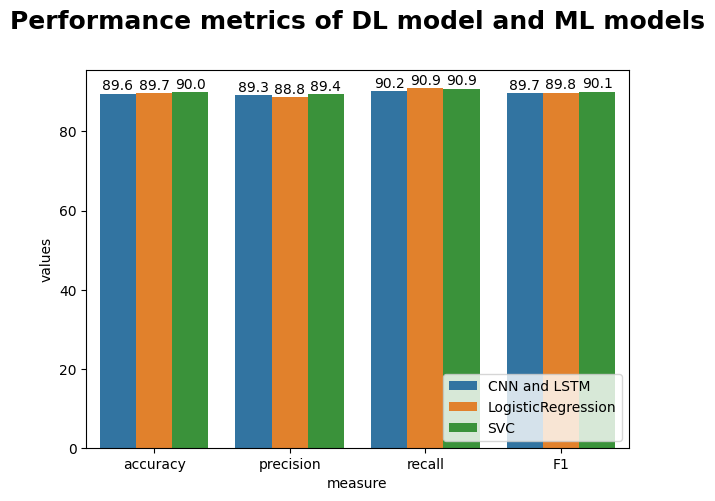

In [47]:
ax = sns.barplot(x='measure', y='values', hue='model', data=comp)
ax.set_title("Performance metrics of DL model and ML models", fontsize=18, pad=30, fontdict={"weight": "bold"})
show_values(ax)
ax.legend(loc='lower right')